In [826]:
import numpy as np
import pandas as pd

In [827]:
rho_tank=4500 #kg/m3
m=24/86400#ton/s
P=410#bar
T=273.15+25
T1=T
Tref=10+273.15
Po=31

In [828]:
import pandas as pd
crit=pd.DataFrame()
crit['Comp']=['H2']
crit['Tc']=[32.938]
crit['Pc']=[1293.00]
crit['w']=[-0.2160]
crit['PM']=[1.00784*2]
T=298
#P1=100
def PRv2(Tc,Pc,mm,w,T,P):
    #Unidades: P, Pc: kPa, T, Tc: K, w: Adim, mm: kg/kmol
    R=8.314#J/mol-K
    Ru=R/mm
    mi=0.379642+1.48503*w-0.164423*w**2+0.016666*w**3
    alpha=(1+mi*(1-(T/Tc)**0.5))**2
    a=0.45724*((Ru)**2)*(Tc**2)*alpha/(Pc)
    b=0.0778*(Ru)*(Tc/Pc)
    A_may=a*P/(((Ru)**2)*(T**2))
    B_may=b*P/((Ru)*T)
    m=-(1-B_may)
    n=(A_may-(3*B_may**2)-(2*B_may))
    o=-((A_may*B_may)-(B_may**2)-(B_may**3))
    v=(Ru*T)/P
    return {'alpha':alpha,'a':a,'b':b,'A':A_may,'B':B_may,'m':m,'n':n,'o':o,'v':v}
resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],316+273.15,172.37*100)
z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
#r1=(P1*crit['PM'][0])/(z*(8.314)*(T+273.15))
#V1=m/r1
#V1

In [829]:
import numpy as np
from scipy.optimize import root
def trabajo_reversible(m, P1, P2, eta, T2,T1):
    P1=P1*100
    P2=P2*100
    
    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T1,P1)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r1=(P1*crit['PM'][0])/(z*(8.314)*T1)
    
    V1=1/r1
    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T2+273.15,P2)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r2=(P2*crit['PM'][0])/(z*(8.314)*(T2+273.15))
    V2=1/r2
    n = np.log(P2/P1)/(np.log((V1)/(V2)))
    
    term1 = (m * P1 * 1000 * V1) / (0.72*(n - 1)/n)
    term2 = (P2 / P1) ** ((n - 1) / n) - 1
    W_rev=term1*term2/1000
    return W_rev/eta

def trabajo_reversible_IT(tt, m, P1, P2, eta,T1):
    P1=P1*100
    P2=P2*100
    T2=abs(tt[0])

    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T1,P1)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r1=(P1*crit['PM'][0])/(z*(8.314)*T1)

    V1=1/r1
    resul_peng=PRv2(crit['Tc'][0],crit['Pc'][0],crit['PM'][0],crit['w'][0],T2,P2)
    z=np.real(max(np.roots([1,resul_peng['m'],resul_peng['n'],resul_peng['o']])))
    r2=(P2*crit['PM'][0])/(z*(8.314)*(T2))
    V2=1/r2
    n = np.log(P2/P1)/(np.log((V1)/(V2)))
    
    term1 = (1 * P1 * V1 * 1000) / (0.72*(n - 1)/n)
    term2 = (P2 / P1) ** ((n - 1) / n) - 1
    Tref=T1
    T=T2
    HhH2=(19.67099783*(T-Tref) + 0.069681519/2*(T**2-Tref**2) - 0.000200098/3*(T**3-Tref**3) + 2.89493E-07/4*(T**4-Tref*4) - 2.22475E-10/5*(T**5-Tref**5) + 8.81466E-14/6*(T**6-Tref**6) - 1.42043E-17/7*(T**6-Tref**6))/2
    HhH2=HhH2
    T=T1
    HhH1=(19.67099783*(T-Tref) + 0.069681519/2*(T**2-Tref**2) - 0.000200098/3*(T**3-Tref**3) + 2.89493E-07/4*(T**4-Tref*4) - 2.22475E-10/5*(T**5-Tref**5) + 8.81466E-14/6*(T**6-Tref**6) - 1.42043E-17/7*(T**6-Tref**6))/2
    HhH1=HhH1
    W_rev=term1*term2/1000
    print('kW',W_rev)
    return W_rev - (HhH2 - HhH1)

P1=31
P2=141.82
m=m
eta=0.75
sol = root(trabajo_reversible_IT, x0=500, args=(m, P1, P2, eta,298.15), method='hybr')
if sol.success:
    print(sol.message)
else:
    print(sol.message)

resultado = trabajo_reversible(m, P1, P2, eta, sol.x[0]-273.15,298.15)
print(f"W: {resultado:.20f} kW")
sol.x-273.15

kW 3496.8473861408834
kW 3496.8473861408834
kW 3496.8473861408834
kW 3496.84741376228
kW 3677.64368506432
kW 3676.072128824285
kW 3676.08623771237
kW 3676.086238880761
The solution converged.
W: 1.36151342180768941681 kW


array([275.93059926])

In [830]:
Tref

283.15

In [831]:
import numpy as np
from scipy.optimize import root

def balance(x, T, Tref, m):
    global e
    global s
    """
    Calcula la función de balance para el proceso,
    devolviendo la diferencia e - s.

    Parámetros:
      x    : vector de incógnitas; se asume que x[0] es la variable a encontrar.
      T    : temperatura en K.
      Tref : temperatura de referencia en K.
      m    : masa del hidrógeno (kg).

    La función utiliza dos series polinómicas (para H2 y H2O)
    para calcular, respectivamente, las energías 'e' y 's', y retorna e - s.
    """
    # Calcular la entalpía (u otra propiedad) para hidrógeno
    Ta=15+273.15
    Ts=92+273.15
    HhH2 = ( 19.67099783*(T - Tref)
              + (0.069681519/2) * (T**2 - Tref**2)
              - (0.000200098/3) * (T**3 - Tref**3)
              + (2.89493E-07/4) * (T**4 - Tref**4)
              - (2.22475E-10/5) * (T**5 - Tref**5)
              + (8.81466E-14/6) * (T**6 - Tref**6)
              - (1.42043E-17/7) * (T**7 - Tref**7)
            ) / 2
    

    # Calcular la entalpía (u otra propiedad) para agua (H2O)
    HhH2O = ( -22.41701677*(Ta - Tref)
               + (0.876972156/2) * (Ta**2 - Tref**2)
               - (0.002570393/3) * (Ta**3 - Tref**3)
               + (2.48383E-06/4) * (Ta**4 - Tref**4)
             ) / 18.015
    Tk=25+273.15
    HhH22 = ( 19.67099783*(Tk - Tref)
              + (0.069681519/2) * (Tk**2 - Tref**2)
              - (0.000200098/3) * (Tk**3 - Tref**3)
              + (2.89493E-07/4) * (Tk**4 - Tref**4)
              - (2.22475E-10/5) * (Tk**5 - Tref**5)
              + (8.81466E-14/6) * (Tk**6 - Tref**6)
              - (1.42043E-17/7) * (Tk**7 - Tref**7)
            ) / 2
    

    # Calcular la entalpía (u otra propiedad) para agua (H2O)
    HhH2O2 = ( -22.41701677*(Ts - Tref)
               + (0.876972156/2) * (Ts**2 - Tref**2)
               - (0.002570393/3) * (Ts**3 - Tref**3)
               + (2.48383E-06/4) * (Ts**4 - Tref**4)
             ) / 18.015
    m=m*1e3
    s = (HhH22 + HhH2O2)* x[0]
    e = (HhH2 + HhH2O) * m
    
    return e - s


In [832]:

import pandas as pd
import math

class PriceCalculator:
    def __init__(self, dataframe,spares,material):
        self.dataframe = dataframe
        self.spares = spares
        self.material = material
        self.calculate_price()

    def calculate_price(self):
        prices = []
        cepci_2001 = 397
        cepci_2024 = 798.8
        k1=2.2897
        k2=1.3604
        k3=-0.1027
        if self.material == "Carbon Steel":
            sFBM=3.4
        elif self.material == "Stainless Steel":
            sFBM=7.0
        else:
            sFBM=13.9 #for Nickel Alloy
        FBMCS=3.4 #for Carbon Steel

        for index, row in self.dataframe.iterrows():
            if index < len(self.dataframe) - 1:  # For all rows except the last one
                w_value = row["W (kW)"]
                A = k1+(k2*math.log10(w_value))+(k3*(math.log10(w_value)**2))
                B=(10**A)*(self.spares+1)/cepci_2001*cepci_2024
                price=B*sFBM/FBMCS
                prices.append(price)
            else:  # For the last row
                total_price = sum(prices)
                prices.append(total_price)
        self.dataframe["Purchased Equipment Cost (USD)"] = prices
        self.dataframe["Purchased Equipment Cost (USD)"] = self.dataframe["Purchased Equipment Cost (USD)"].apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
        self.total_price = prices[-1]  # Total price is the last value in the list
        installation_cost = total_price * 2.5
        piping_cost = self.total_price * 0.21
        electrical_cost = self.total_price * 0.16
        instrumentation_cost = self.total_price * 0.08
        Final_cost = self.total_price + piping_cost + electrical_cost + instrumentation_cost+installation_cost
        cost_mxn= Final_cost * 19.59 
        pricce_mxn=self.total_price*19.59


        # Create a data frame with the extra costs
        extras = {
            "Purchased Equipment Cost (USD)": [self.total_price],
            "Purchased Equipment Cost (MXN)": [pricce_mxn],
            "Installation Cost (USD)": [installation_cost],
            "Piping Cost (USD)": [piping_cost],
            "Electrical Cost (USD)": [electrical_cost],
            "Instrumentation Cost (USD)": [instrumentation_cost],
            "Final Cost (USD)": [Final_cost],
            "Final Cost (MXN)": [cost_mxn]
            
        }
        self.extras_df = pd.DataFrame(extras)
        # Format the numbers in the extras_df as currency
        self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
        self.final=Final_cost
        return self.dataframe, self.extras_df

# Use the class with the prueba dataframe
SS="Stainless Steel"
CS="Carbon Steel"
NA="Nickel Alloy"



In [833]:
import numpy as np
from scipy.optimize import root

def calcular_dimension_tanque(P, m, crit, tipo, rho_tank, T=300, x0=[1, 4]):
    """
    Calcula las dimensiones, espesor y masa de un tanque en base a parámetros de entrada.
    
    Parámetros:
      - P: Presión de entrada (se espera en unidades que requieran ser convertidas a Pascales).
      - m: Masa (kg) o cantidad similar requerida para el cálculo del volumen.
      - crit: Diccionario con las propiedades críticas, debe incluir las claves:
              'Tc', 'Pc', 'PM' y 'w'. Se usan los primeros elementos (ej: crit['Tc'][0]).
      - tipo: Tipo de tanque, str. Debe ser 'hemi' o 'semi'.
      - rho_tank: Densidad del material del tanque (kg/m³).
      - T: Temperatura en Kelvin (por defecto 300 K).
      - x0: Valor inicial para la solución del sistema [r, L] (por defecto [1.5, 3.0]).
      
    Retorna:
      Un diccionario con los siguientes valores:
        - 'volumen_total': Volumen calculado del tanque (m³).
        - 'radio': Radio del tanque (m).
        - 'longitud': Longitud del tanque (m).
        - 'espesor': Espesor del tanque (m).
        - 'masa': Masa del tanque (ton).
        - 'V_objetivo': Volumen objetivo calculado (m³).
    
    Se lanzará un ValueError en caso de que el sistema no encuentre solución o 
    si el tipo de tanque no es reconocido.
    """
    
    # Se recalcula V_objetivo usando el método de Peng–Robinson (se asume PRv2 está definida)
    resul_peng = PRv2(crit['Tc'][0], crit['Pc'][0], crit['PM'][0], crit['w'][0], T, (P)*100)
    z = np.real(max(np.roots([1, resul_peng['m'], resul_peng['n'], resul_peng['o']])))
    r1 = (100 * P * crit['PM'][0]) / (z * 8.314 * T)
    V1 = m / r1
    V_objetivo = V1

    # Definición del sistema de ecuaciones para resolver por el método root
    def ecuaciones(x, V_obj):
        r, L = abs(x[0]), abs(x[1])
        if tipo == 'hemi':
            V_tank = (4 / 3) * np.pi * r**3 + (L - 2*r) * np.pi * r**2
        elif tipo == 'semi':
            V_tank = np.pi * r**2 * L + (2/3) * np.pi * r**3
        else:
            raise ValueError("Tipo de tanque no reconocido. Usa 'hemi' o 'semi'.")
        
        f1 = V_tank - V_obj  # La diferencia entre el volumen calculado y el objetivo
        f2 = L - 4 * r     # Relación de diseño entre L y r
        return [f1, f2]

    # Resolver el sistema de ecuaciones
    solucion = root(
    ecuaciones, 
    x0=x0, 
    args=(V_objetivo,), 
    method='hybr', 
    tol=1e-3, 
    options={'maxfev': 10000000}  # limite máximo de evaluaciones (iteraciones)
)

    if not solucion.success:
        raise ValueError("No se encontró solución: " + solucion.message)
    
    r, L_encontrado = solucion.x[0], solucion.x[1]

    # Calcular el volumen total del tanque según el tipo
    if tipo == 'hemi':
        V_total_sol = (4 / 3) * np.pi * r**3 + (L_encontrado - 2*r) * np.pi * r**2
    elif tipo == 'semi':
        V_total_sol = (2 / 3) * np.pi * r**3 + (L_encontrado - r) * np.pi * r**2
    else:
        raise ValueError("Tipo de tanque no reconocido. Usa 'hemi' o 'semi'.")

    # Cálculo del espesor del tanque usando una ecuación de pared delgada
    FS = 1.5  # Factor de seguridad
    Sy = 2811 * 100000
    Su = 3095 * 100000
    t1 = (100000*P * r * FS) / Sy
    t2 = (100000*P * r * 2.25) / Su
    t = max(t1, t2)  # Espesor del tanque (en metros)

    # Para el cálculo de la masa se asume h = r
    h = r
    if tipo == 'hemi':
        mt = rho_tank * ((4/3) * np.pi * (r + t)**3 + np.pi * (r + t)**2 * L_encontrado - V_objetivo)
    elif tipo == 'semi':
        mt = rho_tank * (np.pi * ((r + t)**2 * L_encontrado + (2/3) * (r + t)**2 * (h + t)) -
                         (np.pi * r**2 * L_encontrado + (2/3) * np.pi * r**2 * h))
    else:
        raise ValueError("Tipo de tanque no reconocido. Usa 'hemi' o 'semi'.")
    mt = mt / 1000  # Conversión a toneladas

    # Impresión de resultados
    print("Volumen calculado del tanque:", round(V_total_sol, 2), "m³")
    print("Radio del tanque:", round(r, 2), "m")
    print("Longitud del tanque:", round(L_encontrado, 2), "m")
    print("Espesor del tanque:", round(t*1000, 2), "mm")
    print("Masa del tanque:", round(mt, 2), "ton")

    # Retorna los resultados en un diccionario
    return {
        'volumen_total': V_total_sol,
        'radio': r,
        'longitud': L_encontrado,
        'espesor': t,
        'masa': mt,
        'V_objetivo': V_objetivo,
        'h2':m
    }

# Ejemplo de uso:
# Se debe definir o importar la función PRv2 y el diccionario crit apropiadamente.

import pandas as pd
crit=pd.DataFrame()
crit['Comp']=['H2']
crit['Tc']=[32.938]
crit['Pc']=[1293.00]
crit['w']=[-0.2160]
crit['PM']=[1.00784*2]

class TankCostCalculator:
    price_per_lb_gas = {
        "Type I": 5.5,
        "Type II": 9.0,
        "Type III & IV": 15.5
    }

    def __init__(self, tank_type, gas_mass_kg):
        self.tank_type = tank_type
        self.gas_mass_kg = gas_mass_kg
        self.gas_mass_lb = gas_mass_kg * 2.20462  # in lb
        self.price_per_lb = self.price_per_lb_gas[tank_type]
        self.extras_df = self.calculate_cost()  # Call calculate_cost during initialization

    def calculate_cost(self):
        CEPCI_2014 = 576.1
        CEPCI_2024 = 798.8
        self.price= (self.gas_mass_lb * self.price_per_lb)* (CEPCI_2024 / CEPCI_2014)
        self.total_material_cost= self.price * 1.2  
        self.construction= self.price * 0.08
        installation_cost = self.price * 2.5
        instrumentation_cost = self.price * 0.08
        Final_cost = self.price + self.total_material_cost + self.construction + installation_cost + instrumentation_cost
        cost_mxn= Final_cost * 19.61  
        self.final=Final_cost
        # Create a data frame with the extra costs
        extras = {
            "Total Price (FOB)": [self.price],
            "Installation Cost (USD)": [installation_cost],
            "Total Material Cost (USD)": [self.total_material_cost],
            "Construction Cost (USD)": [self.construction],
            "Instrumentation Cost (USD)": [instrumentation_cost],
            "Final Cost (USD)": [Final_cost],
            "Final Cost (MXN)": [cost_mxn]
        }
        self.extras_df = pd.DataFrame(extras)
        # Format the numbers in the extras_df as currency
        self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)       
        return  self.extras_df


T1="Type I"
T2="Type II"
T3="Type III & IV"



In [834]:
Pes=list(np.linspace(110,500))

In [835]:
m

0.0002777777777777778

In [836]:
Tref=283.15

In [837]:
def pressure_increment_per_stage(P1, P2, n):
    """
    Calcula el factor de incremento de presión (r) en cada etapa de compresión, y
    devuelve las presiones en cada etapa.
    
    Parámetros:
      P1 : float
          Presión inicial.
      P2 : float
          Presión final.
      n : int
          Número de etapas de compresión.
          
    Retorna:
      r : float
          Factor multiplicativo de presión por etapa.
      pressures : list
          Lista con la presión en cada etapa, desde la inicial hasta la final.
    """
    # Calcular el factor de incremento por etapa
    r = (P2 / P1) ** (1 / n)
    
    # Calcular la presión en cada etapa
    pressures = [P1 * r**i for i in range(n + 1)]
    
    return r, pressures


In [838]:
import pandas as pd
import numpy as np
from scipy.optimize import root

# Inicialización de listas y acumulador de resultados
stages = []
temperature = []
compis = []
Qk = []
Wk = []
waterr = []
price_list = []
resultados_list = []  # Aquí se guardarán los diccionarios con los resultados de cada iteración

for i in range(len(Pes)):
    # Configuración inicial por cada presión en Pes
    P = Pes[i]
    Po = 31
    P_diff = P - Po
    P1_inicial = Po
    P2_target = P

    # Cálculo del número de etapas
    N_etapas = np.ceil(np.log((P2_target) / (Po)) / np.log(2))
    stages.append(N_etapas)

    r, pressures = pressure_increment_per_stage(Po, P2_target, int(N_etapas))
    pressures.pop(0)
    # Se calcula el valor “sin límite” para el incremento de presión en cada etapa
    

    # Se inicializa la lista de presiones. El primer valor es la presión base Po.
    P_acum = [Po]
    Temps = [25 + 273.15]

    # Inicialización de contenedores para los datos de cada etapa
    Qs, Ts, m_H2O, comp, power, Ps_list = [], [], [], [], [], []
    Tcomp = []  # Para almacenar "T comp" en cada etapa
    eta = 0.75
    Tref_val = Tref  # Se asume que Tref ya está definida

    # Iterar por cada etapa
    for j in range(int(N_etapas)):
        # Se define, para cada etapa, el incremento permitido:
        if j == 0:
            # En la primera etapa no puede superar 2·Po
            allowed_increment = 2 * Po
        else:
            # En etapas posteriores se toma el incremento usado en la etapa anterior (almacenado en P_acum[-1])
            # y se limita a su doble.
            allowed_increment = 2 * P_acum[-1]

        # Se aplica la restricción: se toma el mínimo entre el valor calculado originalmente y el permitido.
        p_etapa_actual = pressures[j]/2

        # Se calculan las presiones de entrada y salida de la etapa
        P1 = sum(P_acum)
        P_acum.append(p_etapa_actual)
        P2 = sum(P_acum)

        

        # Resolver para el trabajo reversible utilizando root
        x0 = [1.0]
        sol = root(trabajo_reversible_IT, x0=[500], args=(m, P1, P2, eta, 298.15), method='hybr')
        if sol.success:
            print(sol.message)
        else:
            print(sol.message)

        # Cálculo del trabajo y otros parámetros
        tkñ = sol.x[0]  # Valor obtenido para T2 (en K)
        #print('kkkkkkk', tkñ)
        resultado = trabajo_reversible(m, P1, P2, eta, tkñ - 273.15, 298.15)
        #print(f"W: {resultado:.20f} kW")

        # Resolver la ecuación de balance
        solucion = root(balance, x0, args=(tkñ, Tref_val, m), method='hybr')
        if solucion.success:
            x_encontrado = solucion.x[0]
            

            # Se actualizan los acumuladores de datos de la etapa
            Temps.append(25 + 273.15)
            Qs.append(float(-e))      # Se asume que "e" está definido
            Ts.append(25 + 273.15)
            m_H2O.append(float(x_encontrado))
            comp.append('No. ' + str(j + 1))
            power.append(resultado * 1e3)
            Ps_list.append(P2)
            Tcomp.append(tkñ - 273.15)
        else:
            print("No se encontró solución:", solucion.message)

    # Resto del código (agrupación de resultados, cálculo de costos, etc.)
    data = {
        "Compressor": comp,
        "T (K)": Ts,
        "P (bar)": Ps_list,  # Se asume que el valor está en bar
        "Cooling H2O (kg/s)": m_H2O,
        "Q (kW)": np.array(Qs),
        "W (kW)": np.array(power),
        "T comp": Tcomp
    }
    df_compresores = pd.DataFrame(data)

    total_row = [
        "Total",
        Temps[-1],
        Ps_list[-1],
        sum(df_compresores['Cooling H2O (kg/s)']),
        sum(df_compresores['Q (kW)']),
        sum(df_compresores['W (kW)']),
        sum(df_compresores['T comp'])
    ]
    df_compresores.loc[df_compresores.shape[0]] = total_row
    compis.append(df_compresores)
    
    # Se instancia el PriceCalculator; se asume que devuelve la información requerida.
    calculator = PriceCalculator(df_compresores, N_etapas, CS)
    calculator_info = {
        "volumen_total": calculator.volumen_total if hasattr(calculator, 'volumen_total') else None,
        "radio":         calculator.radio         if hasattr(calculator, 'radio')         else None,
        "longitud":      calculator.longitud      if hasattr(calculator, 'longitud')      else None,
        "espesor":       calculator.espesor       if hasattr(calculator, 'espesor')       else None,
        "masa":          calculator.masa          if hasattr(calculator, 'masa')          else None,
        "V_objetivo":    calculator.V_objetivo    if hasattr(calculator, 'V_objetivo')    else None,
        "h2":            m  # Se utiliza el valor de m definido externamente
    }
    
    # Actualizar las listas agregadas con información del renglón "Total" de df_compresores
    tot_idx = df_compresores.shape[0] - 1
    temperature.append(df_compresores.loc[tot_idx]['T (K)'])
    Qk.append(df_compresores.loc[tot_idx]['Q (kW)'])
    Wk.append(df_compresores.loc[tot_idx]['W (kW)'])
    waterr.append(df_compresores.loc[tot_idx]['Cooling H2O (kg/s)'])
    
    # Cálculo de dimensiones del tanque y su costo
    resultadot = calcular_dimension_tanque(df_compresores.loc[tot_idx]['P (bar)'], (((m*86400)*1e3)*(4/24))*2.5, crit, 'hemi', 4500)
    calculator1 = TankCostCalculator("Type I", resultadot['masa'] * 1e3)
    
    total_price =  calculator1.final + calculator.final
    price_list.append(total_price)
    
    # Crear un diccionario que combine los datos totales y la info de calculator
    resultado_row = {
        "T (K)": df_compresores.loc[tot_idx]['T (K)'],
        "P (bar)": df_compresores.loc[tot_idx]['P (bar)'],
        "Cooling H2O (kg/s)": df_compresores.loc[tot_idx]['Cooling H2O (kg/s)'],
        "Q (kW)": df_compresores.loc[tot_idx]['Q (kW)'],
        "W (kW)": df_compresores.loc[tot_idx]['W (kW)'],
        "volumen_total": calculator_info["volumen_total"],
        "radio":         calculator_info["radio"],
        "longitud":      calculator_info["longitud"],
        "espesor":       calculator_info["espesor"],
        "masa":          calculator_info["masa"],
        "V_objetivo":    calculator_info["V_objetivo"],
        "h2":            calculator_info["h2"],
        "price":         total_price,
        "It. No.":       i
    }
    resultados_list.append(resultado_row)

# Crear el DataFrame final de resultados a partir de la lista
df_resultados = pd.DataFrame(resultados_list)
df_resultados

kW 1505.7281928518257
kW 1505.7281928518257
kW 1505.7281928518257
kW 1505.7282049188043
kW 1320.7886618397667
kW 1318.7699236860242
kW 1318.7467519679897
kW 1318.7467487361869
The solution converged.
kW 1493.362189049124
kW 1493.362189049124
kW 1493.362189049124
kW 1493.362200885982
kW 1310.6707971934752
kW 1308.6699610148034
kW 1308.646879793529
kW 1308.6468765397715
The solution converged.
Volumen calculado del tanque: 1122.89 m³
Radio del tanque: 4.75 m
Longitud del tanque: 19.0 m
Espesor del tanque: 397.86 mm
Masa del tanque: 4641.44 ton
kW 1544.771827784924
kW 1544.771827784924
kW 1544.771827784924
kW 1544.7718401628347
kW 1359.7972844212923
kW 1357.8019724712196
kW 1357.7794320905318
kW 1357.779429054953
The solution converged.
kW 1553.7128582481405
kW 1553.7128582481405
kW 1553.7128582481405
kW 1553.7128705510568
kW 1371.123832550833
kW 1369.161987527636
kW 1369.139926669821
kW 1369.1399237287615
The solution converged.
Volumen calculado del tanque: 1078.39 m³
Radio del tanque: 

/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 1407.1296555329436
The solution converged.
kW 1643.0124897549954
kW 1643.0124897549954
kW 1643.0124897549954
kW 1643.0125023696244
kW 1467.7519739696013
kW 1465.9836279142546
kW 1465.965199891975
kW 1465.9651977943051
The solution converged.
Volumen calculado del tanque: 558.92 m³
Radio del tanque: 3.77 m
Longitud del tanque: 15.06 m
Espesor del tanque: 673.58 mm
Masa del tanque: 3327.94 ton
kW 1389.3661324496795
kW 1389.3661324496795
kW 1389.3661324496795
kW 1389.3661435891818
kW 1206.0594818069826
kW 1203.9962283059533
kW 1203.9714863432084
kW 1203.9714825417668
The solution converged.
kW 1315.911844704577
kW 1315.911844704577
kW 1315.911844704577
kW 1315.9118551627685
kW 1136.4965620000416
kW 1134.4411459721737
kW 1134.4158216129097
kW 1134.415817483486
The solution converged.
kW 1294.8248420413054
kW 1294.8248420413054
kW 1294.8248420413054
kW 1294.8248521537184
kW 1119.6111442515623
kW 1117.6165404945382
kW 1117.592097754458
kW 1117.5920938035922
The solution converged.
kW 1315

/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 1315.373514602262
The solution converged.
kW 1526.5533003479202
kW 1526.5533003479202
kW 1526.5533003479202
kW 1526.5533121436622
kW 1348.9546284708572
kW 1347.0723694076598
kW 1347.0515023049916
kW 1347.0514995927995
The solution converged.
kW 1606.1572224077754
kW 1606.1572224077754
kW 1606.1572224077754
kW 1606.157234136813
kW 1440.367861878511
kW 1438.7863744417962
kW 1438.7708889850494
kW 1438.770887418426
The solution converged.
Volumen calculado del tanque: 357.93 m³
Radio del tanque: 3.25 m
Longitud del tanque: 12.98 m
Espesor del tanque: 988.18 mm
Masa del tanque: 3108.61 ton
kW 1515.6235432439328
kW 1515.6235432439328
kW 1515.6235432439328
kW 1515.6235553897282
kW 1330.6505986340348
kW 1328.6373991337514
kW 1328.614382754033
kW 1328.6143795718508
The solution converged.
kW 1508.6222582484247
kW 1508.6222582484247
kW 1508.6222582484247
kW 1508.622270203275
kW 1325.8979496540005
kW 1323.9060173046266
kW 1323.8831829418823
kW 1323.8831797670148
The solution converged.
kW 1537

/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW),volumen_total,radio,longitud,espesor,masa,V_objetivo,h2,price,It. No.
0,298.15,115.197603,1.529710,-860.595124,973.108750,None,None,None,None,None,None,0.000278,3.868724e+08,0
1,298.15,120.215062,1.578767,-888.193744,1009.970131,None,None,None,None,None,None,0.000278,3.778903e+08,1
2,298.15,158.149488,1.932384,-1087.134598,1187.588079,None,None,None,None,None,None,0.000278,3.336667e+08,2
3,298.15,164.285295,1.974914,-1111.061025,1219.531157,None,None,None,None,None,None,0.000278,3.283692e+08,3
4,298.15,170.368935,2.015863,-1134.098431,1250.288639,None,None,None,None,None,None,0.000278,3.235695e+08,4
5,298.15,176.404632,2.055370,-1156.324610,1279.964284,None,None,None,None,None,None,0.000278,3.192171e+08,5
6,298.15,182.396056,2.093555,-1177.807086,1308.648154,None,None,None,None,None,None,0.000278,3.152317e+08,6
7,298.15,188.346429,2.130523,-1198.604895,1336.418992,None,None,None,None,None,None,0.000278,3.116005e+08,7
8,298.15,194.258589,2.166367,-1218.769990,1363.346089,None,None,None,None,None,None,0.000278,3.082761e+08,8
9,298.15,200.135059,2.201167,-1238.348360,1389.490785,None,None,None,None,None,None,0.000278,3.052276e+08,9


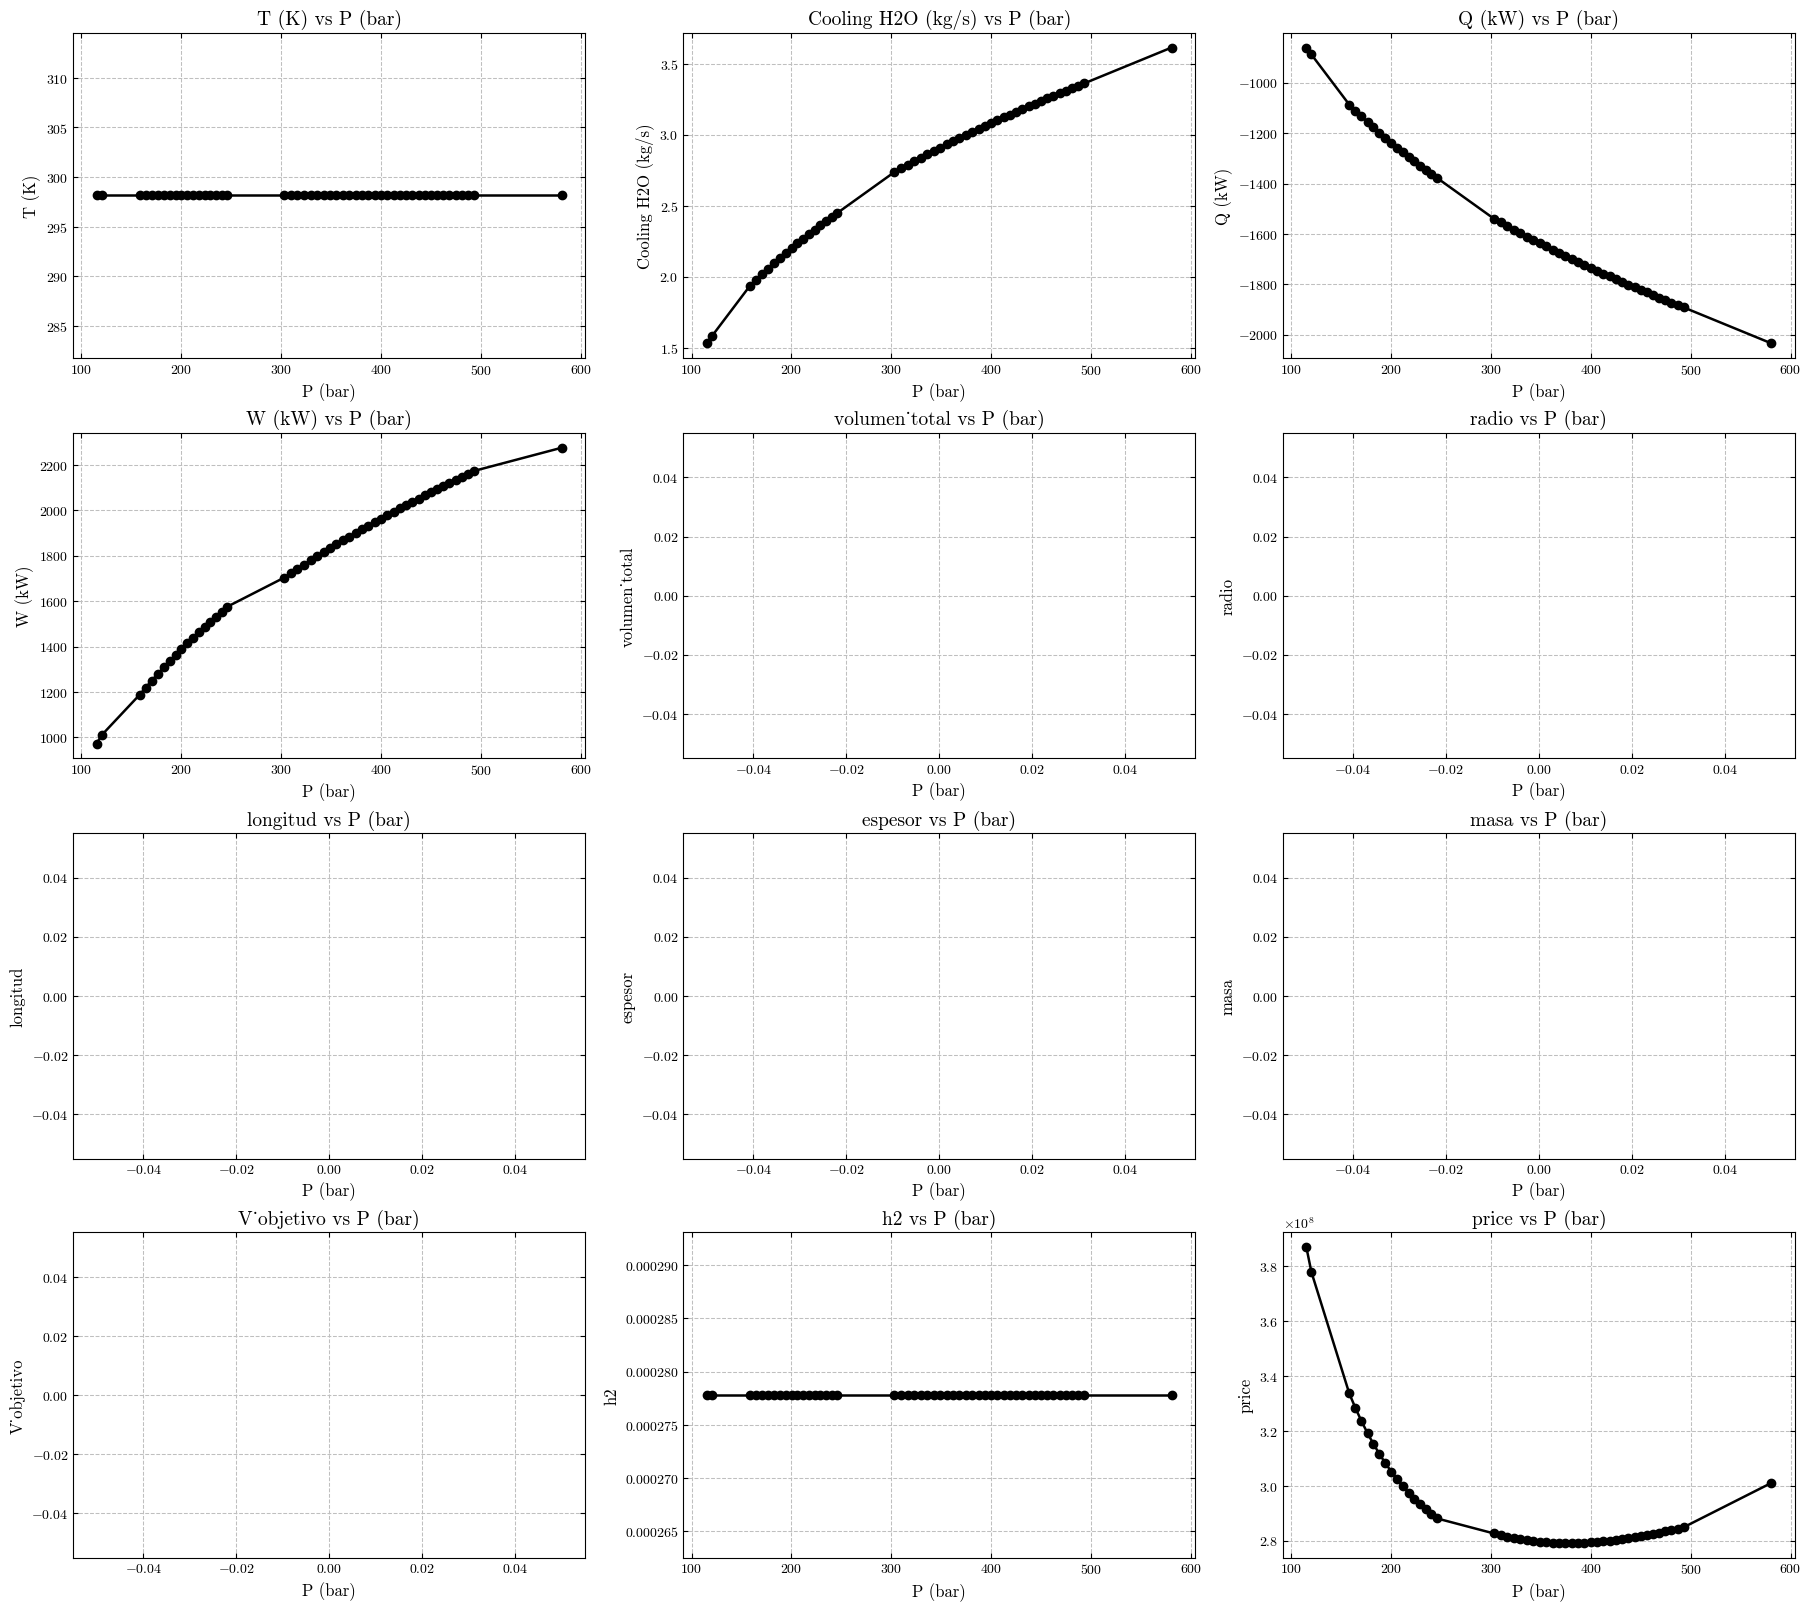

In [839]:
import matplotlib.pyplot as plt
import scienceplots  # Asegúrate de tener instalado: pip install SciencePlots
import math

# Desactivar el uso de LaTeX para evitar el error.
#plt.rcParams['text.usetex'] = False

# Utiliza una combinación de estilos populares para obtener un formato científico
#plt.style.use(['science'])#, 'ieee', 'std-colors'])

# Lista de variables a graficar versus "P (bar)"
variables_to_plot = [
    "T (K)",
    "Cooling H2O (kg/s)",
    "Q (kW)",
    "W (kW)",
    "volumen_total",
    "radio",
    "longitud",
    "espesor",
    "masa",
    "V_objetivo",
    "h2",
    "price"
]

# Se asume que df_resultados ya está definido y contiene la columna "P (bar)" y las demás variables
df_resultados_sorted = df_resultados.sort_values(by="P (bar)")
import pandas as pd

# Se asume que df_resultados_sorted ya está definido y contiene la columna 'price'

# Calcular el primer (Q1) y tercer cuartil (Q3)
q1 = df_resultados_sorted['price'].quantile(0.25)
q3 = df_resultados_sorted['price'].quantile(0.75)

# Calcular el rango intercuartílico (IQR)
IQR = q3 - q1

# Definir los límites inferior y superior para detectar outliers
lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

# Filtrar el DataFrame eliminando los valores atípicos en la columna 'price'
df_resultados_filtrado = df_resultados_sorted[
    (df_resultados_sorted['price'] >= lower_bound) &
    (df_resultados_sorted['price'] <= upper_bound)
]
df_resultados_sorted=df_resultados_sorted
# Opcional: Mostrar el DataFrame filtrado


num_vars = len(variables_to_plot)
cols = 3
rows = math.ceil(num_vars / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), constrained_layout=True)
axes = axes.flatten()

# Graficar cada variable versus "P (bar)"
for i, var in enumerate(variables_to_plot):
    ax = axes[i]
    ax.plot(
        df_resultados_sorted["P (bar)"],
        df_resultados_sorted[var],
        marker="o", linestyle="-", color="black"
    )
    ax.set_xlabel("P (bar)")
    ax.set_ylabel(var)
    ax.set_title(f"{var} vs P (bar)")
    ax.grid(True)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)

# Eliminar axes vacíos en caso de que excedan el total de variables
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


In [840]:
mini=df_resultados_sorted[df_resultados_sorted['price']==df_resultados_sorted['price'].min()]
mini

,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW),volumen_total,radio,longitud,espesor,masa,V_objetivo,h2,price,It. No.
29,298.15,374.609993,2.998886,-1687.134502,1900.736213,None,None,None,None,None,None,0.000278,2.791744e+08,29


In [841]:
compis[mini.index[0]]

,Compressor,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW),T comp,Purchased Equipment Cost (USD)
0,No. 1,298.15,59.224183,0.749123,-421.447041,474.734252,113.299302,"$1,576,452.88"
1,No. 2,298.15,110.618020,0.734403,-413.165647,463.674806,111.255336,"$1,546,576.76"
2,No. 3,298.15,204.201830,0.741266,-417.026816,468.831161,112.208372,"$1,560,532.34"
3,No. 4,298.15,374.609993,0.774093,-435.494998,493.495994,116.765737,"$1,626,663.56"
4,Total,298.15,374.609993,2.998886,-1687.134502,1900.736213,453.528746,"$6,310,225.54"


In [856]:
k=compis[df_resultados['It. No.'][mini.index[0]]]
k['Cooling H2O (ton/d)']=(k['Cooling H2O (kg/s)']*86400)/1e3*(4/24) #ton
k

,Compressor,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW),T comp,Purchased Equipment Cost (USD),Cooling H2O (ton/d)
0,No. 1,298.15,59.224183,0.749123,-421.447041,474.734252,113.299302,"$1,576,452.88",10.787373
1,No. 2,298.15,110.618020,0.734403,-413.165647,463.674806,111.255336,"$1,546,576.76",10.575402
2,No. 3,298.15,204.201830,0.741266,-417.026816,468.831161,112.208372,"$1,560,532.34",10.674233
3,No. 4,298.15,374.609993,0.774093,-435.494998,493.495994,116.765737,"$1,626,663.56",11.146945
4,Total,298.15,374.609993,2.998886,-1687.134502,1900.736213,453.528746,"$6,310,225.54",43.183954


In [843]:
k['P (bar)'][k.shape[0]-1]

np.float64(374.60999304875963)

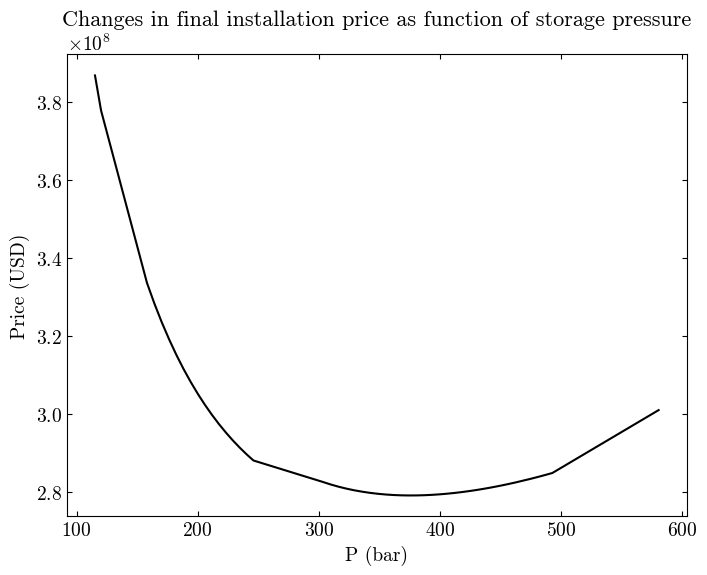

In [844]:
import matplotlib.pyplot as plt
#import scienceplots  # Asegúrate de tener instalado: pip install SciencePlots

# Opcional: activar un estilo popular (en este ejemplo usamos 'no-latex')
plt.style.use(['no-latex'])

# Se asume que df_resultados ya está definido y contiene las columnas "P (bar)" y "price"
#df_resultados_sorted = df_resultados.sort_values(by="P (bar)")

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar 'price' en función de 'P (bar)'
ax.plot(df_resultados_sorted["P (bar)"], df_resultados_sorted["price"],
        linestyle="-", color="black",lw=1.5)

# Personalizar etiquetas y título
ax.set_xlabel("P (bar)", fontsize=14)
ax.set_ylabel("Price (USD)", fontsize=14)
ax.set_title("Changes in final installation price as function of storage pressure", fontsize=16)

# Activar la grilla y ajustar los ticks para un formato profesional

ax.tick_params(axis="both", which="major", labelsize=14, direction="in", top=True, right=True)
ax.tick_params(axis="both", which="minor", labelsize=12, direction="in", top=True, right=True)

# Forzar notación científica (esto hará que se muestre la notación ×10^...)
ax.ticklabel_format(axis="both", style="sci")

# Aumentar el tamaño de la fuente de la notación científica (offset text)
ax.xaxis.get_offset_text().set_fontsize(14)
ax.yaxis.get_offset_text().set_fontsize(14)

plt.show()


In [845]:
import matplotlib.pyplot as plt

# Imprime todos los estilos disponibles en Matplotlib
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'bright', 'cjk-jp-font', 'cjk-kr-font', 'cjk-sc-font', 'cjk-tc-font', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'grid', 'high-contrast', 'high-vis', 'ieee', 'latex-sans', 'light', 'muted', 'nature', 'no-latex', 'notebook', 'petroff10', 'pgf', 'retro', 'russian-font', 'sans', 'scatter', 'science', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'std-colors', 'tableau-colorblind10', 'turkish-font', 'vibrant']


Parámetros ajustados:
a = -176.3248595915227
n = 314998720.6348168


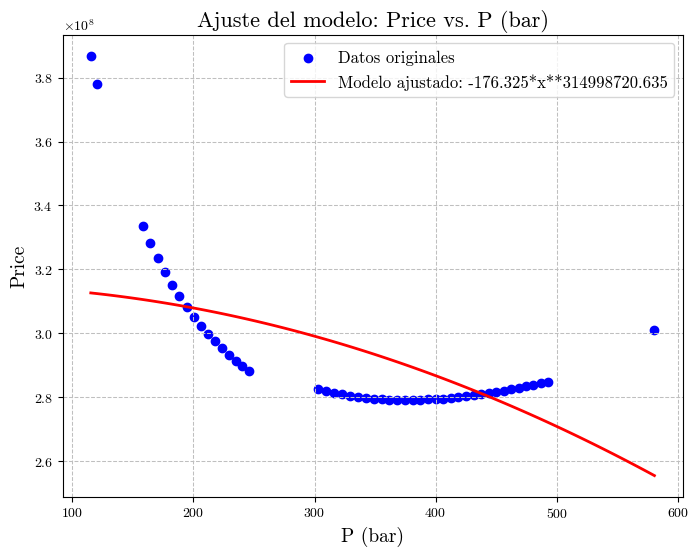

In [846]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Se asume que df_resultados ya está definido y contiene las columnas:
# 'P (bar)' -> variable independiente (x)
# 'price'   -> variable dependiente (y)
#
# Si deseas probar con datos simulados, puedes descomentar el siguiente bloque:
# df_resultados = pd.DataFrame({
#     "P (bar)": np.linspace(10, 100, 20),
#     "price": 2.5 * np.linspace(10, 100, 20)**1.2 + np.random.normal(0, 20, 20)
# })

# Extraer los datos
x = df_resultados['P (bar)'].values
y = df_resultados['price'].values

# Definir el modelo: f(x) = a * x^n
def model_func(x, a, n):
    return a * x**2+n

# Estimar valores iniciales para los parámetros (p0) es muy importante en la optimización no lineal
p0 = [1.0, 1.0]  # a = 1, n = 1, por ejemplo

# Ajuste del modelo usando curve_fit
# Usamos el método 'trf' para que se puedan pasar parámetros de tolerancia (xtol) y max_nfev
popt, pcov = curve_fit(
    model_func, 
    x, 
    y, 
    p0=p0, 
    method='trf', 
    xtol=1e-3,         # Tolerancia en los cambios en la solución 
    max_nfev=10000      # Número máximo de evaluaciones de la función
)

# Los parámetros optimizados se almacenan en popt
a_fit, n_fit = popt

print("Parámetros ajustados:")
print("a =", a_fit)
print("n =", n_fit)

# Crear puntos para graficar el modelo ajustado en el rango de los datos
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = model_func(x_fit, a_fit, n_fit)

# Graficar los datos originales y la curva ajustada
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Datos originales', color='blue')
plt.plot(x_fit, y_fit, label=f'Modelo ajustado: {a_fit:.3f}*x**{n_fit:.3f}', color='red', linewidth=2)
plt.xlabel("P (bar)", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.title("Ajuste del modelo: Price vs. P (bar)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


Coeficientes ajustados:
a = 1134.1666262132553
b = -871985.0129751487
c = 442420548.8094516


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 243 (\N{LATIN SMALL LETTER O WITH ACUTE}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


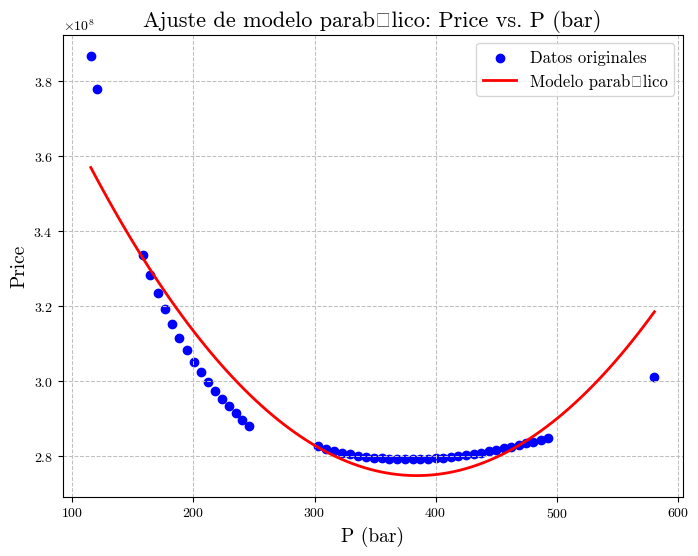

In [847]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que df_resultados ya está definido y contiene las columnas:
# 'P (bar)' para la presión y 'price' para el costo.
# Ejemplo de datos simulados (comenta o elimina estas líneas al trabajar con tus datos reales)
# df_resultados = pd.DataFrame({
#     "P (bar)": np.linspace(10, 100, 20),
#     "price": 0.05 * np.linspace(10, 100, 20)**2 - 2 * np.linspace(10, 100, 20) + 200 + np.random.normal(0, 20, 20)
# })

# Extraer datos de las columnas de interés
x = df_resultados['P (bar)'].values
y = df_resultados['price'].values

# Ajuste de un polinomio de grado 2 (parábola) a los datos
coeffs = np.polyfit(x, y, 2)  # coeffs = [a, b, c]
fitted_poly = np.poly1d(coeffs)

print("Coeficientes ajustados:")
print("a =", coeffs[0])
print("b =", coeffs[1])
print("c =", coeffs[2])

# Crear puntos para graficar la función ajustada
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = fitted_poly(x_fit)

# Graficar los datos originales y la curva ajustada
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Datos originales', color='blue')
plt.plot(x_fit, y_fit, label='Modelo parabólico', color='red', linewidth=2)
plt.xlabel("P (bar)", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.title("Ajuste de modelo parabólico: Price vs. P (bar)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [848]:
stages,temperature,Qk,Wk,waterr,price=[],[],[],[],[],[]
for i in range(len(Pes)):
    P=Pes[i]
    Po=31
    P_diff=P-Po
    P1=Po
    P2=P
    N_etapas=np.ceil((np.log(P2)/np.log(P1))/np.log(2))
    stages.append(N_etapas)
    P_etapa=P_diff/N_etapas
    Po=Po
    Pf=P
    P_acum=[Po]
    Temps=[25+273.15]
    Tref=Tref
    m=m
    eta=0.75
    Qs,Ts,m_H2O,comp,power,Ps=[],[],[],[],[],[]
    for i in range(int(N_etapas)):
        P1=sum(P_acum)
        print(P1)
        P_acum.append(P_etapa)
        P2=sum(P_acum)
        #Ti=(sum(P_acum)*V2*2)/(m*Z*8.314)
        #print('T',Ti)
        # Valor inicial para la incógnita x (en este caso, es un vector de una dimensión)
        x0 = [1.0]
        sol = root(trabajo_reversible_IT, x0=500, args=(m, P1, P2, eta,298.15), method='hybr')
        if sol.success:
            print(sol.message)
        else:
            print(sol.message)

        resultado = trabajo_reversible(m, P1, P2, eta, sol.x[0]-273.15,298.15)
        print(f"W: {resultado:.20f} kW")
        # Se utiliza scipy.optimize.root con método 'hybr'
        solucion = root(balance, x0, args=(sol.x[0],Tref, m), method='hybr')

        if solucion.success:
            x_encontrado = solucion.x[0]
            print(f"Solución encontrada: x = {x_encontrado:.6f}")
            Temps.append(25+273.15)
            Qs.append(float(-e))
            Ts.append((25+273.15))
            m_H2O.append(float(x_encontrado))
            comp.append('No. '+str(i+1))
            CP=19.67099783 + 0.069681519*T - 0.000200098*T**2 + 2.89493E-07*T**3 - 2.22475E-10*T**4 + 8.81466E-14*T**5 - 1.42043E-17*T**6
            CP=CP/2*1000
            power.append(resultado*1e3)
            Ps.append(P2)
        else:
            print("No se encontró solución:", solucion.message)
    # Crear un DataFrame con los datos
    data = {
        "Compressor": comp,
        "T (K)": Ts,
        "P (bar)": Ps,  # Convertir de Pa a bar
        "Cooling H2O (kg/s)": m_H2O,
        "Q (kW)": np.array(Qs),
        #"Q (kW) Aspen":np.array([-1645.66707374,-775.158866276,-514.144266522]),
        "W (kW)": np.array(power)
        #"W (kW) Aspen":np.array([2211.5522, 1052.84936, 706.504967])
        
    }

    df_compresores = pd.DataFrame(data)

    #df_compresores['Error %']=abs(((df_compresores['Q (kW) Aspen']-df_compresores['Q (kW) Python'])/df_compresores['Q (kW) Aspen']*100 + (df_compresores['W (kW) Aspen']-df_compresores['W (kW) Python'])/df_compresores['W (kW) Aspen']*100)/2)
    df_compresores.loc[df_compresores.shape[0]] = ["Total", Temps[-1], Ps[-1], sum(df_compresores['Cooling H2O (kg/s)']), sum(df_compresores['Q (kW)']), sum(df_compresores['W (kW)'])]
    calculator = PriceCalculator(df_compresores,N_etapas,CS)
    
    
    temperature.append(df_compresores.loc[df_compresores.shape[0]-1]['T (K)'])
    Qk.append(df_compresores.loc[df_compresores.shape[0]-1]['Q (kW)'])
    Wk.append(df_compresores.loc[df_compresores.shape[0]-1]['W (kW)'])
    waterr.append(df_compresores.loc[df_compresores.shape[0]-1]['Cooling H2O (kg/s)'])
    resultadot = calcular_dimension_tanque(P=df_compresores.loc[df_compresores.shape[0]-1]['P (bar)'], m=10000, crit=crit, tipo='hemi', rho_tank=4500)
    
    calculator1 = TankCostCalculator("Type I", resultadot['masa']*1e3)
    price.append(calculator.final+calculator1.final)
    

31
kW 1867.2835333955588
kW 1867.2835333955588
kW 1867.2835333955588
kW 1867.2835483360004
kW 1692.125003213775
kW 1690.4741173340667
kW 1690.4582729397364
kW 1690.4582714369349
The solution converged.
W: 0.62609565608775374912 kW
Solución encontrada: x = 0.950502
70.5
kW 1024.654754246111
kW 1024.654754246111
kW 1024.654754246111
kW 1024.654762370594
kW 862.9168037527157
kW 860.9828037583148
kW 860.9569083348937
kW 860.9569032420858
kW 860.9569032420729
The solution converged.
W: 0.31887292712669362826 kW
Solución encontrada: x = 0.541610
Volumen calculado del tanque: 1173.28 m³
Radio del tanque: 4.82 m
Longitud del tanque: 19.28 m
Espesor del tanque: 385.51 mm
Masa del tanque: 4769.93 ton
31
kW 1497.7025185121695
kW 1497.7025185121695
kW 1497.7025185121695
kW 1497.7025305152174
kW 1312.8022937216715
kW 1310.7792644132874
kW 1310.755969107277
kW 1310.755965835311
The solution converged.
W: 0.48546517253159676697 kW
Solución encontrada: x = 0.763405
59.98639455782313
kW 903.11275995652

/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

Volumen calculado del tanque: 315.97 m³
Radio del tanque: 3.11 m
Longitud del tanque: 12.45 m
Espesor del tanque: 1113.59 mm
Masa del tanque: 3146.72 ton
31
kW 4168.989154844884
kW 4168.989154844884
kW 4168.989154844884
kW 4168.9891874651175
kW 4666.001870560476
kW 4653.687618515367
kW 4654.024037161865
kW 4654.024309665507
kW 4654.024309659333
The solution converged.
W: 1.72371270728123460181 kW
Solución encontrada: x = 2.398260
187.33333333333334
kW 1489.3516094146528
kW 1489.3516094146528
kW 1489.3516094146528
kW 1489.3516205302583
kW 1318.9208196761995
kW 1317.1739028500792
kW 1317.155221379934
kW 1317.1552191078047
The solution converged.
W: 0.48783526633622381619 kW
Solución encontrada: x = 0.766560
343.6666666666667
kW 979.2904246214674
kW 979.2904246214674
kW 979.2904246214674
kW 979.2904315567627
kW 840.3552369204929
kW 838.8619194018547
kW 838.8440605495476
kW 838.844057707102
kW 838.844057707097
The solution converged.
W: 0.31068298433596180930 kW
Solución encontrada: x = 0.

/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)


In [849]:
resultados=pd.DataFrame()
resultados['P (bar)']=Pes
resultados['Stages']=stages
resultados['Q (kW)']=Qk
resultados['W (kW)']=Wk
resultados['H2O (kg/s)']=waterr
resultados['Price (USD)']=price

/tmp/ipykernel_48527/4128071261.py:84: UserWarning: Glyph 243 (\N{LATIN SMALL LETTER O WITH ACUTE}) missing from font(s) cmr10.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 243 (\N{LATIN SMALL LETTER O WITH ACUTE}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


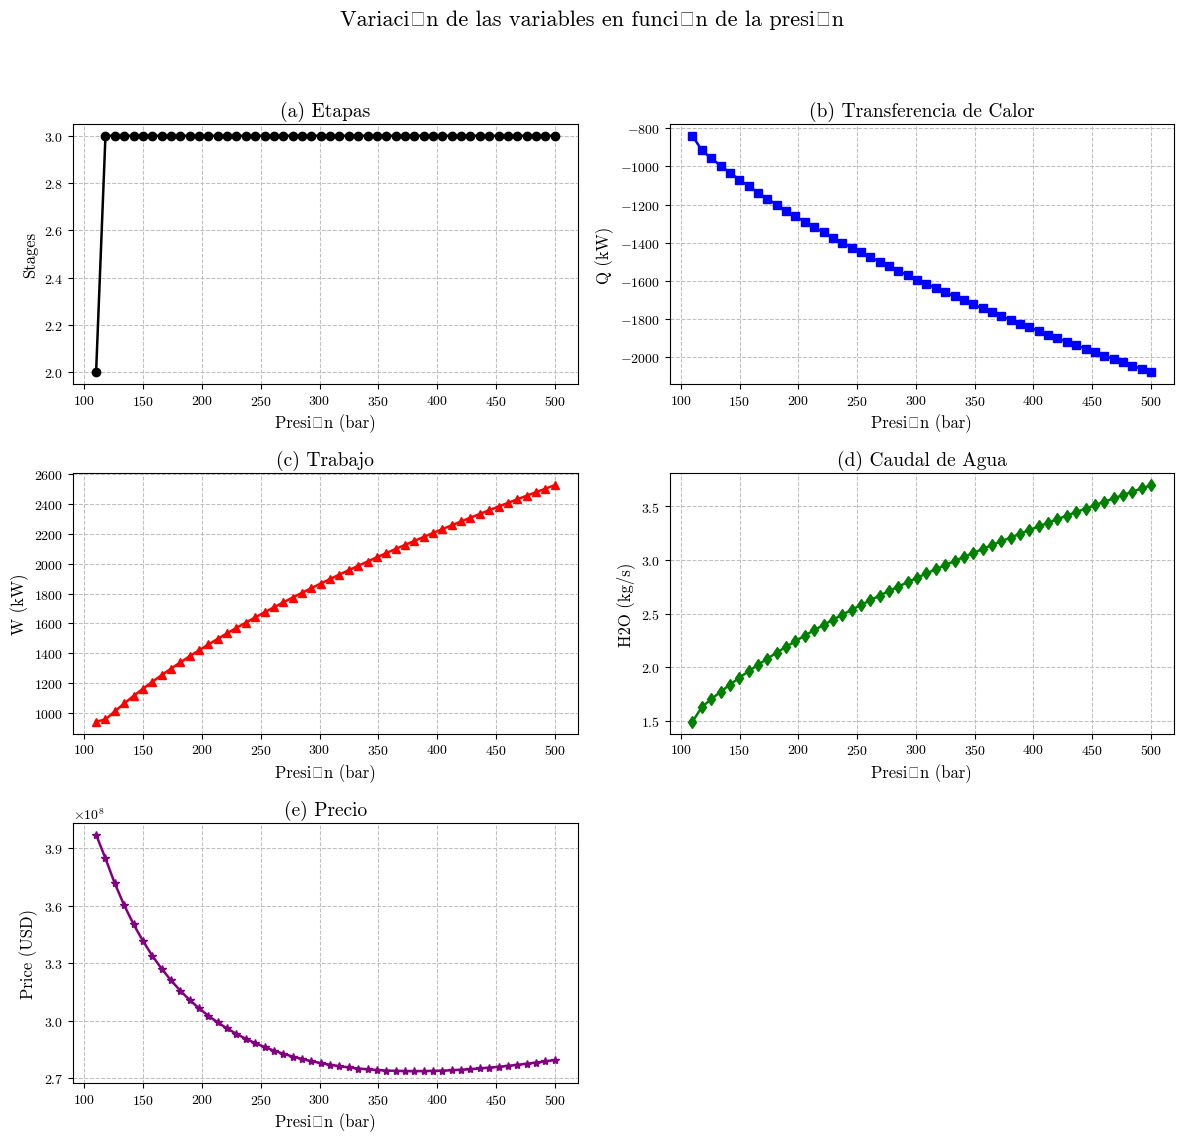

In [850]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker  # Para controlar la cantidad de ticks en el eje y

# Aplicamos el estilo clásico y actualizamos algunos parámetros estéticos
#plt.style.use('classic')
plt.rcParams.update({
    'font.size': 12,             # Tamaño global de fuente
    'axes.labelsize': 12,        # Tamaño de las etiquetas de los ejes
    'axes.titlesize': 14,        # Tamaño de los títulos de los ejes
    'xtick.labelsize': 10,       # Tamaño de las etiquetas del eje x
    'ytick.labelsize': 10,       # Tamaño de las etiquetas del eje y
    'lines.linewidth': 1.8,      # Grosor de las líneas
    'lines.markersize': 6,       # Tamaño de los marcadores
    'grid.linestyle': '--',      # Estilo discontínuo para la rejilla
    'grid.linewidth': 0.75,      # Grosor de la rejilla
    'grid.color': '0.75',        # Color gris para la rejilla
})

# Se asume que las variables Pes, stages, Qk, Wk, waterr y price ya están definidas
resultados = pd.DataFrame({
    'P (bar)': Pes,
    'Stages': stages,
    'Q (kW)': Qk,
    'W (kW)': Wk,
    'H2O (kg/s)': waterr,
    'Price (USD)': price
})

# Configuración de la figura con 3 filas y 2 columnas (sin sharex para mostrar todos los valores en X)
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Variación de las variables en función de la presión', fontsize=16, fontweight='bold')

# Panel (a): Stages vs. Presión
axs[0, 0].plot(resultados['P (bar)'], resultados['Stages'],
               marker='o', linestyle='-', color='black')
axs[0, 0].set_ylabel('Stages')
axs[0, 0].set_title('(a) Etapas')
axs[0, 0].grid(True)
axs[0, 0].set_axisbelow(True)
axs[0, 0].set_xlabel('Presión (bar)')  # Se muestran los valores del eje de la presión

# Panel (b): Q (kW) vs. Presión
axs[0, 1].plot(resultados['P (bar)'], resultados['Q (kW)'],
               marker='s', linestyle='-', color='blue')
axs[0, 1].set_ylabel('Q (kW)')
axs[0, 1].set_title('(b) Transferencia de Calor')
axs[0, 1].grid(True)
axs[0, 1].set_axisbelow(True)
axs[0, 1].set_xlabel('Presión (bar)')

# Panel (c): W (kW) vs. Presión
axs[1, 0].plot(resultados['P (bar)'], resultados['W (kW)'],
               marker='^', linestyle='-', color='red')
axs[1, 0].set_ylabel('W (kW)')
axs[1, 0].set_title('(c) Trabajo')
axs[1, 0].grid(True)
axs[1, 0].set_axisbelow(True)
axs[1, 0].set_xlabel('Presión (bar)')

# Panel (d): H2O (kg/s) vs. Presión
axs[1, 1].plot(resultados['P (bar)'], resultados['H2O (kg/s)'],
               marker='d', linestyle='-', color='green')
axs[1, 1].set_ylabel('H2O (kg/s)')
axs[1, 1].set_title('(d) Caudal de Agua')
axs[1, 1].grid(True)
axs[1, 1].set_axisbelow(True)
axs[1, 1].set_xlabel('Presión (bar)')

# Panel (e): Price (USD) vs. Presión
axs[2, 0].plot(resultados['P (bar)'], resultados['Price (USD)'],
               marker='*', linestyle='-', color='purple')
axs[2, 0].set_ylabel('Price (USD)')
axs[2, 0].set_title('(e) Precio')
axs[2, 0].grid(True)
axs[2, 0].set_axisbelow(True)
axs[2, 0].set_xlabel('Presión (bar)')
# Reducir el número de ticks en el eje y a un máximo de 5 para el gráfico de Price
axs[2, 0].yaxis.set_major_locator(ticker.MaxNLocator(5))

# Ocultamos el panel vacío (última celda de la cuadrícula)
axs[2, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [851]:


P=172
Po=31
P_diff=P-Po
P1=Po
P2=P
N_etapas=np.ceil((np.log(P2)/np.log(P1))/np.log(2))
N_etapas
P_etapa=P_diff/N_etapas
Po=Po
Pf=P
P_acum=[Po]
Temps=[25+273.15]
Tref=Tref
m=m
eta=0.75
Qs,Ts,m_H2O,comp,power,Ps=[],[],[],[],[],[]
for i in range(int(N_etapas)):
    P1=sum(P_acum)
    print(P1)
    P_acum.append(P_etapa)
    P2=sum(P_acum)
    #Ti=(sum(P_acum)*V2*2)/(m*Z*8.314)
    #print('T',Ti)
    # Valor inicial para la incógnita x (en este caso, es un vector de una dimensión)
    x0 = [1.0]
    sol = root(trabajo_reversible_IT, x0=500, args=(m, P1, P2, eta,298.15), method='hybr')
    if sol.success:
        print(sol.message)
    else:
        print(sol.message)

    resultado = trabajo_reversible(m, P1, P2, eta, sol.x[0]-273.15,298.15)
    print(f"W: {resultado:.20f} kW")
    # Se utiliza scipy.optimize.root con método 'hybr'
    solucion = root(balance, x0, args=(sol.x[0],Tref, m), method='hybr')

    if solucion.success:
        x_encontrado = solucion.x[0]
        print(f"Solución encontrada: x = {x_encontrado:.6f}")
        Temps.append(25+273.15)
        Qs.append(float(-e))
        Ts.append((25+273.15))
        m_H2O.append(float(x_encontrado))
        comp.append('No. '+str(i+1))
        CP=19.67099783 + 0.069681519*T - 0.000200098*T**2 + 2.89493E-07*T**3 - 2.22475E-10*T**4 + 8.81466E-14*T**5 - 1.42043E-17*T**6
        CP=CP/2*1000
        power.append(resultado*1e3)
        Ps.append(P2)
    else:
        print("No se encontró solución:", solucion.message)
# Crear un DataFrame con los datos
data = {
	"Compressor": comp,
    "T (K)": Ts,
    "P (bar)": Ps,  # Convertir de Pa a bar
	"Cooling H2O (kg/s)": m_H2O,
	"Q (kW)": np.array(Qs),
    #"Q (kW) Aspen":np.array([-1645.66707374,-775.158866276,-514.144266522]),
    "W (kW)": np.array(power)
    #"W (kW) Aspen":np.array([2211.5522, 1052.84936, 706.504967])
    
}

df_compresores = pd.DataFrame(data)

#df_compresores['Error %']=abs(((df_compresores['Q (kW) Aspen']-df_compresores['Q (kW) Python'])/df_compresores['Q (kW) Aspen']*100 + (df_compresores['W (kW) Aspen']-df_compresores['W (kW) Python'])/df_compresores['W (kW) Aspen']*100)/2)
df_compresores.loc[df_compresores.shape[0]] = ["Total", Temps[-1], Ps[-1], sum(df_compresores['Cooling H2O (kg/s)']), sum(df_compresores['Q (kW)']), sum(df_compresores['W (kW)'])]
df_compresores


31
kW 2099.6081213396997
kW 2099.6081213396997
kW 2099.6081213396997
kW 2099.6081381186063
kW 1943.0449633545518
kW 1941.7791147680246
kW 1941.7688353379679
kW 1941.768834650278
The solution converged.
W: 0.71917364246306603182 kW
Solución encontrada: x = 1.074242
78.0
kW 1090.4662603714667
kW 1090.4662603714667
kW 1090.4662603714667
kW 1090.4662689896174
kW 924.2422462538713
kW 922.2707260516489
kW 922.2448043895358
kW 922.2447994955525
kW 922.24479949554
The solution converged.
W: 0.34157214796131113443 kW
Solución encontrada: x = 0.571839
125.0
kW 750.7507762999617
kW 750.7507762999617
kW 750.7507762999617
kW 750.7507821595873
kW 619.4312736720176
kW 617.8505447917091
kW 617.8282810823689
kW 617.828276158673
kW 617.8282761586584
The solution converged.
W: 0.22882528746616970228 kW
Solución encontrada: x = 0.421671


,Compressor,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW)
0,No. 1,298.15,78.0,1.074242,-604.355007,719.173642
1,No. 2,298.15,125.0,0.571839,-321.709204,341.572148
2,No. 3,298.15,172.0,0.421671,-237.226878,228.825287
3,Total,298.15,172.0,2.067753,-1163.291089,1289.571078


In [852]:

calculator = PriceCalculator(df_compresores,N_etapas,CS)

/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)


In [853]:
calculator.dataframe

,Compressor,T (K),P (bar),Cooling H2O (kg/s),Q (kW),W (kW),Purchased Equipment Cost (USD)
0,No. 1,298.15,78.0,1.074242,-604.355007,719.173642,"$1,752,500.82"
1,No. 2,298.15,125.0,0.571839,-321.709204,341.572148,"$961,111.32"
2,No. 3,298.15,172.0,0.421671,-237.226878,228.825287,"$681,583.84"
3,Total,298.15,172.0,2.067753,-1163.291089,1289.571078,"$3,395,195.98"


In [854]:
Tref

283.15

In [855]:
import numpy as np
import pandas as pd
from scipy.optimize import root, minimize

def normalize_price(price):
    """
    Convierte un valor de precio que puede venir formateado (por ejemplo, "$1,234.56")
    a un número tipo float.
    Si 'price' es un pandas.Series con un solo valor, se extrae ese valor.
    """
    # Si es una serie (con un solo valor), extraer el valor.
    if isinstance(price, pd.Series):
        price = price.iloc[0]
    
    # Si ya es numérico, lo retorna en forma float.
    if isinstance(price, (int, float)):
        return float(price)
    
    if isinstance(price, str):
        # Eliminar símbolos comunes: $, €, espacios y comas
        cleaned = price.replace("$", "").replace("€", "").replace(",", "").strip()
        try:
            return float(cleaned)
        except Exception as ex:
            raise ValueError("No se pudo normalizar el precio: '{}'".format(price))
    # De lo contrario, se intenta convertir a float
    return float(price)

def cost_function(P, m, Tref, T, CS, crit):
    """
    Función objetivo para minimizar; dada una presión P (en bar) calcula el costo total,
    el cual es la suma de:
      - El costo de compresión obtenido con PriceCalculator.
      - El costo del tanque obtenido con TankCostCalculator.
    
    Se normalizan los precios para asegurar que sean float antes de realizar la suma.

    Parámetros:
      - P   : Presión final (en bar). Es la variable independiente a optimizar.
      - m   : Parámetro relacionado a la masa o cantidad a comprimir.
      - Tref: Temperatura de referencia (en Kelvin).
      - T   : Temperatura usada en algunos cálculos (ej. en la ecuación de Cp).
      - CS  : Constante o parámetro requerido por PriceCalculator.
      - crit: Diccionario con las propiedades críticas (keys: 'Tc', 'Pc', 'PM', 'w').
    
    Devuelve:
      total_cost: Suma de los costos (float) de compresión y de tanque.
    """

    # Fijamos la presión de entrada (Po) a 31 bar.
    Po = 31  
    P=P[0]
    if P <= Po:
        # Penalizar fuertemente si la presión final no supera la de entrada.
        return 1e12

    P_diff = P - Po
    P1 = Po
    P2 = P
    # Estimación del número de etapas. Se redondea hacia arriba.
    N_etapas = np.ceil((np.log(P2) / np.log(P1)) / np.log(2))
    # Incremento de presión por etapa:
    P_etapa = P_diff / N_etapas

    # Variables iniciales para las etapas
    P_acum = [Po]            # Acumulador de presión
    Temps = [25 + 273.15]    # Temperatura en Kelvin (25°C + 273.15)
    eta = 0.75               # Eficiencia
    # Inicializar listas para los resultados de cada etapa
    Qs, Ts, m_H2O, comp, power, Ps_list = [], [], [], [], [], []
    
    # Bucle sobre las etapas de compresión:
    for j in range(int(N_etapas)):
        # La presión de entrada actual es la suma de los incrementos acumulados.
        P1_current = sum(P_acum)
        # Agregar la presión de la etapa y actualizar la presión de salida.
        P_acum.append(P_etapa)
        P2_current = sum(P_acum)
        
        # Resolver la ecuación de trabajo reversible (usando una función externa)
        sol = root(trabajo_reversible_IT, x0=500, args=(m, P1_current, P2_current, eta, 298.15), method='hybr')
        if not sol.success:
            return 1e12  # Penalización si no se converge

        # Calcular el trabajo (en kW) usando la función trabajo_reversible.
        # Se utiliza sol.x[0] - 273.15 para convertir de Kelvin a °C.
        resultado = trabajo_reversible(m, P1_current, P2_current, eta, sol.x[0] - 273.15, 298.15)
        
        # Resolver la ecuación de balance (por ejemplo, para obtener el caudal de enfriamiento),
        # usando root con un valor inicial.
        x0_vec = [1.0]
        solucion = root(balance, x0_vec, args=(sol.x[0], Tref, m), method='hybr')
        if not solucion.success:
            return 1e12
        x_encontrado = solucion.x[0]
        
        # Se asume un valor placeholder para "e" (ya que no está definido, se utiliza 0)
        e_value = 0  
        
        # Acumulación de datos para la etapa.
        Temps.append(25 + 273.15)
        Qs.append(float(-e_value))  # Aquí se debe introducir el valor correcto para Q.
        Ts.append(25 + 273.15)
        m_H2O.append(float(x_encontrado))
        comp.append('No. ' + str(j + 1))
        # Se calcula CP con una expresión polinómica (ejemplo, sin utilizarlo directamente)
        CP = (19.67099783 
              + 0.069681519 * T 
              - 0.000200098 * T**2 
              + 2.89493E-07 * T**3 
              - 2.22475E-10 * T**4 
              + 8.81466E-14 * T**5 
              - 1.42043E-17 * T**6)
        CP = CP / 2 * 1000
        
        power.append(resultado * 1e3)  # Convertir a Watts, por ejemplo.
        Ps_list.append(P2_current)
    
    # Armado del DataFrame con información de cada etapa.
    data = {
        "Compressor": comp,
        "T (K)": Ts,
        "P (bar)": Ps_list,  # Se trabaja con P en bar
        "Cooling H2O (kg/s)": m_H2O,
        "Q (kW)": np.array(Qs),
        "W (kW)": np.array(power)
    }
    df_compresores = pd.DataFrame(data)
    # Agregar una fila "Total" que resume los valores.
    total_row = ["Total",
                 Temps[-1],
                 Ps_list[-1],
                 df_compresores["Cooling H2O (kg/s)"].sum(),
                 df_compresores["Q (kW)"].sum(),
                 df_compresores["W (kW)"].sum()]
    df_compresores.loc[df_compresores.shape[0]] = total_row

    # --- Cálculo de costos ---
    # Se obtiene el costo del proceso de compresión.
    calculator = PriceCalculator(df_compresores, N_etapas, CS)
    cost_compression = normalize_price(calculator.final)

    # Se dimensiona el tanque utilizando la función calcular_dimension_tanque.
    resultadot = calcular_dimension_tanque(
        P=sum(Ps_list),
        m=10000,
        crit=crit,
        tipo='hemi',
        rho_tank=4500
    )
    # Se calcula el costo del tanque.
    calculator1 = TankCostCalculator("Type I", resultadot["masa"] * 1e3)
    cost_tank = normalize_price(calculator1.extras_df["Final Cost (USD)"])

    # Sumar ambos costos para obtener el costo total.
    total_cost = cost_compression + cost_tank
    print
    print('TOTAL:',total_cost)
    return total_cost

# --- Ejemplo de optimización usando scipy.minimize ---
if __name__ == '__main__':
    # Parámetros o variables del proceso (se deben definir según tu aplicación)
    m = 4/86400           # Ejemplo: masa o caudal relacionado
    Tref = Tref      # Temperatura de referencia en Kelvin
    T = 298.15         # Temperatura usada para ciertos cálculos (como CP)
    CS = "Carbon Steel"           # Constante para PriceCalculator (ejemplo)
    crit = crit
    
    # Definir límites para la presión óptima (en bar). Po es 31 en el código, así que se debe estar por encima.
    P_min = 50  
    P_max = 1000
    x0 = [900]  # Valor inicial en bar
    
    # Ejecutar la optimización
    res = minimize(cost_function, x0, args=(m, Tref, T, CS, crit),
                   bounds=[(P_min, P_max)])
    
    if res.success:
        print("Presión óptima encontrada (bar):", res.x[0])
        print("Costo total mínimo:", res.fun)
    else:
        print("La optimización falló:", res.message)


kW 5541.063399431749
kW 5541.063399431749
kW 5541.063399431749
kW 5541.0634414469505
kW 7032.575719247068
kW 6900.452524637113
kW 6914.935346060866
kW 6915.153880983119
kW 6915.153488377773
kW 6915.153488388297
kW 1703.815957234465
kW 1703.815957234465
kW 1703.815957234465
kW 1703.8159689704516
kW 1550.800507761304
kW 1549.5135785306297
kW 1549.5026795756426
kW 1549.5026787538607
kW 1151.1566151930156
kW 1151.1566151930156
kW 1151.1566151930156
kW 1151.1566223789655
kW 1021.0558684450076
kW 1019.8721568857829
kW 1019.8606396126753
kW 1019.8606383957296
Volumen calculado del tanque: 144.57 m³
Radio del tanque: 2.4 m
Longitud del tanque: 9.6 m
Espesor del tanque: 3193.18 mm
Masa del tanque: 6887.82 ton
TOTAL: 569388498.4849861
kW 5541.063399459629
kW 5541.063399459629
kW 5541.063399459629
kW 5541.063441474828
kW 7032.575662968159
kW 6900.4525320083
kW 6914.935346325855
kW 6915.153881031335
kW 6915.153488426571
kW 6915.1534884370985
kW 1703.8159572390753
kW 1703.8159572390753
kW 1703.8159

/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 

kW 1150.923064706676
kW 1150.923064706676
kW 1150.923064706676
kW 1150.9230718924375
kW 1020.8071325505833
kW 1019.6230057718719
kW 1019.6114811835012
kW 1019.611479965091
Volumen calculado del tanque: 144.6 m³
Radio del tanque: 2.4 m
Longitud del tanque: 9.6 m
Espesor del tanque: 3191.46 mm
Masa del tanque: 6883.09 ton
TOTAL: 568999810.9983257
kW 4056.4567026456407
kW 4056.4567026456407
kW 4056.4567026456407
kW 4056.456734443018
kW 4492.971474015955
kW 4483.553706208847
kW 4483.775045229974
kW 4483.775176606379
kW 4483.775176604507
kW 1471.9088342090529
kW 1471.9088342090529
kW 1471.9088342090529
kW 1471.908845247879
kW 1300.6425723975794
kW 1298.8658330317935
kW 1298.8465474471914
kW 1298.8465450282001
kW 967.15116696768
kW 967.15116696768
kW 967.15116696768
kW 967.1511738719919
kW 827.89805812059
kW 826.3855540364417
kW 826.3672222616495
kW 826.3672192656475
kW 826.3672192656417
Volumen calculado del tanque: 198.36 m³
Radio del tanque: 2.67 m
Longitud del tanque: 10.66 m
Espesor del

/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated.

kW 2155.497187174219
kW 2155.497187174219
kW 2155.497187174219
kW 2155.497204394313
kW 2004.8942525797208
kW 2003.7325045408616
kW 2003.7235261490139
kW 2003.7235256066322
kW 1105.2755904210371
kW 1105.2755904210371
kW 1105.2755904210371
kW 1105.2755991487868
kW 938.1630690350345
kW 936.1853576380771
kW 936.1594693621279
kW 936.1594645224255
kW 936.1594645224133
kW 758.3760839830413
kW 758.3760839830413
kW 758.3760839830413
kW 758.3760898934468
kW 626.3465444549794
kW 624.7589025209351
kW 624.7365980280434
kW 624.7365931216128
kW 624.7365931215977
Volumen calculado del tanque: 381.67 m³
Radio del tanque: 3.32 m
Longitud del tanque: 13.26 m
Espesor del tanque: 931.58 mm
Masa del tanque: 3108.42 ton
TOTAL: 256764880.31561002
kW 2155.4971871409834
kW 2155.4971871409834
kW 2155.4971871409834
kW 2155.497204361078
kW 2004.8942517871374
kW 2003.7325044980487
kW 2003.7235261119952
kW 2003.723525569615
kW 1105.2755904123396
kW 1105.2755904123396
kW 1105.2755904123396
kW 1105.2755991400895
kW 93

/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/2595008889.py:160: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  self.extras_df = self.extras_df.applymap(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_48527/1972708371.py:62: FutureWarning: DataFrame.applymap has been deprecated. 